In [1]:
import tensorflow as tf

In [2]:
data_name = 'oxford_flowers102'

In [3]:
import tensorflow_datasets as tfds

(train,test,validation), info = tfds.load(
    data_name,
    split=['test','train','validation'],
    data_dir="dataset\\",
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    batch_size=-1
)

In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

In [5]:
train_images,train_labels = tfds.as_numpy(train)
test_images,test_labels = tfds.as_numpy(test)
validation_images,validation_labels = tfds.as_numpy(validation)

In [6]:
import cv2
import numpy as np

def preprocessing(images,label):
    images_ = []
    
    for i in range(len(images)):
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(224,224),interpolation = cv2.INTER_AREA)
        image = image/127.5-1.0
        image = image.astype('float16')
        
        images_.append(image)
        
    label = label.astype('uint16')
    images = np.array(images_)
    return images,label

In [7]:
train_images,train_labels = preprocessing(train_images,train_labels)
print(f"Train images shape:{train_images.shape}\nTrain labels shape:{train_labels.shape}")

Train images shape:(6149, 224, 224, 3)
Train labels shape:(6149,)


In [8]:
test_images,test_labels = preprocessing(test_images,test_labels)
print(f"Test images shape:{test_images.shape}\nTest labels shape:{test_labels.shape}")

Test images shape:(1020, 224, 224, 3)
Test labels shape:(1020,)


In [9]:
validation_images,validation_labels = preprocessing(validation_images,validation_labels)
print(f"Validation images shape:{validation_images.shape}\nValidation labels shape:{validation_labels.shape}")

Validation images shape:(1020, 224, 224, 3)
Validation labels shape:(1020,)


In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((test_images,test_labels)).batch(32)

validation_ds = tf.data.Dataset.from_tensor_slices((validation_images,validation_labels)).batch(32)

In [11]:
del train
del test
del validation
del train_images
del test_images
del validation_images
del train_labels
del test_labels
del validation_labels

In [12]:
class ResNet50(tf.keras.models.Model):
    def __init__(self):
        super(ResNet50, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(64,(7,7),strides=(2,2),padding="same")
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        self.maxpool = tf.keras.layers.MaxPool2D((3,3),strides=(2,2))
        
        """ ~~~~~~~~~~~~ 1-bosqich ~~~~~~~~~~~~ """
        """ --- Conv Block --- """
        # 1-qadam
        self.convblock1_conv1 = tf.keras.layers.Conv2D(64,(1,1),strides=1,padding="valid")
        self.convblock1_batch1 = tf.keras.layers.BatchNormalization()
        self.convblock1_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.convblock1_conv2 = tf.keras.layers.Conv2D(64,(3,3),strides=1,padding="same")
        self.convblock1_batch2 = tf.keras.layers.BatchNormalization()
        self.convblock1_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.convblock1_conv3 = tf.keras.layers.Conv2D(256,(1,1),strides=1,padding="valid")
        self.convblock1_batch3 = tf.keras.layers.BatchNormalization()
        self.convblock1_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        # 2-qadam
        self.convblock1_convf = tf.keras.layers.Conv2D(256,(1,1),strides=1,padding="valid")
        self.convblock1_batchf = tf.keras.layers.BatchNormalization()
        
        
        """ --- Identity Block --- """
        self.identityblock11_conv1 = tf.keras.layers.Conv2D(64,(1,1),strides=1,padding="valid")
        self.identityblock11_batch1 = tf.keras.layers.BatchNormalization()
        self.identityblock11_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock11_conv2 = tf.keras.layers.Conv2D(64,(3,3),strides=1,padding="same")
        self.identityblock11_batch2 = tf.keras.layers.BatchNormalization()
        self.identityblock11_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock11_conv3 = tf.keras.layers.Conv2D(256,(1,1),strides=1,padding="valid")
        self.identityblock11_batch3 = tf.keras.layers.BatchNormalization()
        self.identityblock11_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock11_activation_last = tf.keras.layers.Activation(tf.keras.activations.relu)

        """ --- Identity Block --- """
        self.identityblock12_conv1 = tf.keras.layers.Conv2D(64,(1,1),strides=1,padding="valid")
        self.identityblock12_batch1 = tf.keras.layers.BatchNormalization()
        self.identityblock12_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock12_conv2 = tf.keras.layers.Conv2D(64,(3,3),strides=1,padding="same")
        self.identityblock12_batch2 = tf.keras.layers.BatchNormalization()
        self.identityblock12_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock12_conv3 = tf.keras.layers.Conv2D(256,(1,1),strides=1,padding="valid")
        self.identityblock12_batch3 = tf.keras.layers.BatchNormalization()
        self.identityblock12_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock12_activation_last = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        """ ~~~~~~~~~~~~ 2-bosqich ~~~~~~~~~~~~ """
        """ --- Conv Block --- """
        # 1-qadam
        self.convblock2_conv1 = tf.keras.layers.Conv2D(128,(1,1),strides=2,padding="valid")
        self.convblock2_batch1 = tf.keras.layers.BatchNormalization()
        self.convblock2_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.convblock2_conv2 = tf.keras.layers.Conv2D(128,(3,3),strides=1,padding="same")
        self.convblock2_batch2 = tf.keras.layers.BatchNormalization()
        self.convblock2_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.convblock2_conv3 = tf.keras.layers.Conv2D(512,(1,1),strides=1,padding="valid")
        self.convblock2_batch3 = tf.keras.layers.BatchNormalization()
        self.convblock2_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        # 2-qadam
        self.convblock2_convf = tf.keras.layers.Conv2D(512,(1,1),strides=2,padding="valid")
        self.convblock2_batchf = tf.keras.layers.BatchNormalization()
        
        
        """ --- Identity Block --- """
        self.identityblock21_conv1 = tf.keras.layers.Conv2D(128,(1,1),strides=1,padding="valid")
        self.identityblock21_batch1 = tf.keras.layers.BatchNormalization()
        self.identityblock21_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock21_conv2 = tf.keras.layers.Conv2D(128,(3,3),strides=1,padding="same")
        self.identityblock21_batch2 = tf.keras.layers.BatchNormalization()
        self.identityblock21_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock21_conv3 = tf.keras.layers.Conv2D(512,(1,1),strides=1,padding="valid")
        self.identityblock21_batch3 = tf.keras.layers.BatchNormalization()
        self.identityblock21_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock21_activation_last = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        """ --- Identity Block --- """
        self.identityblock22_conv1 = tf.keras.layers.Conv2D(128,(1,1),strides=1,padding="valid")
        self.identityblock22_batch1 = tf.keras.layers.BatchNormalization()
        self.identityblock22_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock22_conv2 = tf.keras.layers.Conv2D(128,(3,3),strides=1,padding="same")
        self.identityblock22_batch2 = tf.keras.layers.BatchNormalization()
        self.identityblock22_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock22_conv3 = tf.keras.layers.Conv2D(512,(1,1),strides=1,padding="valid")
        self.identityblock22_batch3 = tf.keras.layers.BatchNormalization()
        self.identityblock22_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock22_activation_last = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        """ --- Identity Block --- """
        self.identityblock23_conv1 = tf.keras.layers.Conv2D(128,(1,1),strides=1,padding="valid")
        self.identityblock23_batch1 = tf.keras.layers.BatchNormalization()
        self.identityblock23_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock23_conv2 = tf.keras.layers.Conv2D(128,(3,3),strides=1,padding="same")
        self.identityblock23_batch2 = tf.keras.layers.BatchNormalization()
        self.identityblock23_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock23_conv3 = tf.keras.layers.Conv2D(512,(1,1),strides=1,padding="valid")
        self.identityblock23_batch3 = tf.keras.layers.BatchNormalization()
        self.identityblock23_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock23_activation_last = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        """ ~~~~~~~~~~~~ 3-bosqich ~~~~~~~~~~~~ """
        """ --- Conv Block --- """
        # 1-qadam
        self.convblock3_conv1 = tf.keras.layers.Conv2D(256,(1,1),strides=2,padding="valid")
        self.convblock3_batch1 = tf.keras.layers.BatchNormalization()
        self.convblock3_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.convblock3_conv2 = tf.keras.layers.Conv2D(256,(3,3),strides=1,padding="same")
        self.convblock3_batch2 = tf.keras.layers.BatchNormalization()
        self.convblock3_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.convblock3_conv3 = tf.keras.layers.Conv2D(1024,(1,1),strides=1,padding="valid")
        self.convblock3_batch3 = tf.keras.layers.BatchNormalization()
        self.convblock3_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        # 2-qadam
        self.convblock3_convf = tf.keras.layers.Conv2D(1024,(1,1),strides=2,padding="valid")
        self.convblock3_batchf = tf.keras.layers.BatchNormalization()
        
        
        """ --- Identity Block --- """
        self.identityblock31_conv1 = tf.keras.layers.Conv2D(256,(1,1),strides=1,padding="valid")
        self.identityblock31_batch1 = tf.keras.layers.BatchNormalization()
        self.identityblock31_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock31_conv2 = tf.keras.layers.Conv2D(256,(3,3),strides=1,padding="same")
        self.identityblock31_batch2 = tf.keras.layers.BatchNormalization()
        self.identityblock31_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock31_conv3 = tf.keras.layers.Conv2D(1024,(1,1),strides=1,padding="valid")
        self.identityblock31_batch3 = tf.keras.layers.BatchNormalization()
        self.identityblock31_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock31_activation_last = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        """ --- Identity Block --- """
        self.identityblock32_conv1 = tf.keras.layers.Conv2D(256,(1,1),strides=1,padding="valid")
        self.identityblock32_batch1 = tf.keras.layers.BatchNormalization()
        self.identityblock32_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock32_conv2 = tf.keras.layers.Conv2D(256,(3,3),strides=1,padding="same")
        self.identityblock32_batch2 = tf.keras.layers.BatchNormalization()
        self.identityblock32_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock32_conv3 = tf.keras.layers.Conv2D(1024,(1,1),strides=1,padding="valid")
        self.identityblock32_batch3 = tf.keras.layers.BatchNormalization()
        self.identityblock32_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock32_activation_last = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        """ --- Identity Block --- """
        self.identityblock33_conv1 = tf.keras.layers.Conv2D(256,(1,1),strides=1,padding="valid")
        self.identityblock33_batch1 = tf.keras.layers.BatchNormalization()
        self.identityblock33_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock33_conv2 = tf.keras.layers.Conv2D(256,(3,3),strides=1,padding="same")
        self.identityblock33_batch2 = tf.keras.layers.BatchNormalization()
        self.identityblock33_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock33_conv3 = tf.keras.layers.Conv2D(1024,(1,1),strides=1,padding="valid")
        self.identityblock33_batch3 = tf.keras.layers.BatchNormalization()
        self.identityblock33_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock33_activation_last = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        """ --- Identity Block --- """
        self.identityblock34_conv1 = tf.keras.layers.Conv2D(256,(1,1),strides=1,padding="valid")
        self.identityblock34_batch1 = tf.keras.layers.BatchNormalization()
        self.identityblock34_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock34_conv2 = tf.keras.layers.Conv2D(256,(3,3),strides=1,padding="same")
        self.identityblock34_batch2 = tf.keras.layers.BatchNormalization()
        self.identityblock34_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock34_conv3 = tf.keras.layers.Conv2D(1024,(1,1),strides=1,padding="valid")
        self.identityblock34_batch3 = tf.keras.layers.BatchNormalization()
        self.identityblock34_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock34_activation_last = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        """ --- Identity Block --- """
        self.identityblock35_conv1 = tf.keras.layers.Conv2D(256,(1,1),strides=1,padding="valid")
        self.identityblock35_batch1 = tf.keras.layers.BatchNormalization()
        self.identityblock35_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock35_conv2 = tf.keras.layers.Conv2D(256,(3,3),strides=1,padding="same")
        self.identityblock35_batch2 = tf.keras.layers.BatchNormalization()
        self.identityblock35_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock35_conv3 = tf.keras.layers.Conv2D(1024,(1,1),strides=1,padding="valid")
        self.identityblock35_batch3 = tf.keras.layers.BatchNormalization()
        self.identityblock35_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock35_activation_last = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        """ ~~~~~~~~~~~~ 4-bosqich ~~~~~~~~~~~~ """
        """ --- Conv Block --- """
        # 1-qadam
        self.convblock4_conv1 = tf.keras.layers.Conv2D(512,(1,1),strides=2,padding="valid")
        self.convblock4_batch1 = tf.keras.layers.BatchNormalization()
        self.convblock4_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.convblock4_conv2 = tf.keras.layers.Conv2D(512,(3,3),strides=1,padding="same")
        self.convblock4_batch2 = tf.keras.layers.BatchNormalization()
        self.convblock4_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.convblock4_conv3 = tf.keras.layers.Conv2D(2048,(1,1),strides=1,padding="valid")
        self.convblock4_batch3 = tf.keras.layers.BatchNormalization()
        self.convblock4_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        # 2-qadam
        self.convblock4_convf = tf.keras.layers.Conv2D(2048,(1,1),strides=2,padding="valid")
        self.convblock4_batchf = tf.keras.layers.BatchNormalization()
        
        
        """ --- Identity Block --- """
        self.identityblock41_conv1 = tf.keras.layers.Conv2D(512,(1,1),strides=1,padding="valid")
        self.identityblock41_batch1 = tf.keras.layers.BatchNormalization()
        self.identityblock41_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock41_conv2 = tf.keras.layers.Conv2D(512,(3,3),strides=1,padding="same")
        self.identityblock41_batch2 = tf.keras.layers.BatchNormalization()
        self.identityblock41_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock41_conv3 = tf.keras.layers.Conv2D(2048,(1,1),strides=1,padding="valid")
        self.identityblock41_batch3 = tf.keras.layers.BatchNormalization()
        self.identityblock41_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock41_activation_last = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        """ --- Identity Block --- """
        self.identityblock42_conv1 = tf.keras.layers.Conv2D(512,(1,1),strides=1,padding="valid")
        self.identityblock42_batch1 = tf.keras.layers.BatchNormalization()
        self.identityblock42_activation1 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock42_conv2 = tf.keras.layers.Conv2D(512,(3,3),strides=1,padding="same")
        self.identityblock42_batch2 = tf.keras.layers.BatchNormalization()
        self.identityblock42_activation2 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock42_conv3 = tf.keras.layers.Conv2D(2048,(1,1),strides=1,padding="valid")
        self.identityblock42_batch3 = tf.keras.layers.BatchNormalization()
        self.identityblock42_activation3 = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.identityblock42_activation_last = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        """ ~~~~~~~~~~~~ So'nggi bosqich ~~~~~~~~~~~~ """
        self.avrpool = tf.keras.layers.AveragePooling2D((7,7))
        
        self.flatten = tf.keras.layers.Flatten()
        
        self.dense = tf.keras.layers.Dense(1000,activation=tf.keras.activations.relu)
        self.output_layer = tf.keras.layers.Dense(102,activation=tf.keras.activations.softmax)
        
        
    def call(self,x):
        
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.activation1(x)
        x = self.maxpool(x)

        """ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 1-bosqich boshlandi ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ """
        # Convolutional Block1
        layer11 = self.convblock1_conv1(x)
        layer11 = self.convblock1_batch1(layer11)
        layer11 = self.convblock1_activation1(layer11)

        layer11 = self.convblock1_conv2(layer11)
        layer11 = self.convblock1_batch2(layer11)
        layer11 = self.convblock1_activation2(layer11)

        layer11 = self.convblock1_conv3(layer11)
        layer11 = self.convblock1_batch3(layer11)
        layer11 = self.convblock1_activation3(layer11)

        layer12 = self.convblock1_convf(x)
        layer12 = self.convblock1_batchf(layer12)
        
        x = tf.keras.layers.Add()([layer11,layer12])
        print(layer11.shape,layer12.shape,x.shape)
        # Identity Block1
        layer11 = self.identityblock11_conv1(x)
        layer11 = self.identityblock11_batch1(layer11)
        layer11 = self.identityblock11_activation1(layer11)

        layer11 = self.identityblock11_conv2(layer11)
        layer11 = self.identityblock11_batch2(layer11)
        layer11 = self.identityblock11_activation2(layer11)

        layer11 = self.identityblock11_conv3(layer11)
        layer11 = self.identityblock11_batch3(layer11)
        layer11 = self.identityblock11_activation3(layer11)

        x = tf.keras.layers.Add()([x,layer11])
        print(layer11.shape,x.shape)
        x = self.identityblock11_activation_last(x)

        # Identity Block2
        layer11 = self.identityblock12_conv1(x)
        layer11 = self.identityblock12_batch1(layer11)
        layer11 = self.identityblock12_activation1(layer11)

        layer11 = self.identityblock12_conv2(layer11)
        layer11 = self.identityblock12_batch2(layer11)
        layer11 = self.identityblock12_activation2(layer11)

        layer11 = self.identityblock12_conv3(layer11)
        layer11 = self.identityblock12_batch3(layer11)
        layer11 = self.identityblock12_activation3(layer11)

        x = tf.keras.layers.Add()([x,layer11])
        print(layer11.shape,x.shape)
        x = self.identityblock12_activation_last(x)
        """ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 1-bosqich tugadi ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ """

        """ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 2-bosqich boshlandi ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ """
        # Convolutional Block1
        layer11 = self.convblock2_conv1(x)
        layer11 = self.convblock2_batch1(layer11)
        layer11 = self.convblock2_activation1(layer11)

        layer11 = self.convblock2_conv2(layer11)
        layer11 = self.convblock2_batch2(layer11)
        layer11 = self.convblock2_activation2(layer11)

        layer11 = self.convblock2_conv3(layer11)
        layer11 = self.convblock2_batch3(layer11)
        layer11 = self.convblock2_activation3(layer11)

        layer12 = self.convblock2_convf(x)
        layer12 = self.convblock2_batchf(layer12)

        x = tf.keras.layers.Add()([layer11,layer12])
        print(layer11.shape,layer12.shape,x.shape)
        # Identity Block1
        layer11 = self.identityblock21_conv1(x)
        layer11 = self.identityblock21_batch1(layer11)
        layer11 = self.identityblock21_activation1(layer11)

        layer11 = self.identityblock21_conv2(layer11)
        layer11 = self.identityblock21_batch2(layer11)
        layer11 = self.identityblock21_activation2(layer11)

        layer11 = self.identityblock21_conv3(layer11)
        layer11 = self.identityblock21_batch3(layer11)
        layer11 = self.identityblock21_activation3(layer11)

        x = tf.keras.layers.Add()([x,layer11])
        print(layer11.shape,x.shape)
        x = self.identityblock21_activation_last(x)

        # Identity Block2
        layer11 = self.identityblock22_conv1(x)
        layer11 = self.identityblock22_batch1(layer11)
        layer11 = self.identityblock22_activation1(layer11)

        layer11 = self.identityblock22_conv2(layer11)
        layer11 = self.identityblock22_batch2(layer11)
        layer11 = self.identityblock22_activation2(layer11)

        layer11 = self.identityblock22_conv3(layer11)
        layer11 = self.identityblock22_batch3(layer11)
        layer11 = self.identityblock22_activation3(layer11)

        x = tf.keras.layers.Add()([x,layer11])
        print(layer11.shape,x.shape)
        x = self.identityblock22_activation_last(x)
        
        # Identity Block3
        layer11 = self.identityblock23_conv1(x)
        layer11 = self.identityblock23_batch1(layer11)
        layer11 = self.identityblock23_activation1(layer11)

        layer11 = self.identityblock23_conv2(layer11)
        layer11 = self.identityblock23_batch2(layer11)
        layer11 = self.identityblock23_activation2(layer11)

        layer11 = self.identityblock23_conv3(layer11)
        layer11 = self.identityblock23_batch3(layer11)
        layer11 = self.identityblock23_activation3(layer11)

        x = tf.keras.layers.Add()([x,layer11])
        print(layer11.shape,x.shape)
        x = self.identityblock23_activation_last(x)
        """ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 2-bosqich tugadi ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ """

        """ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 3-bosqich boshlandi ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ """
        # Convolutional Block1
        layer11 = self.convblock3_conv1(x)
        layer11 = self.convblock3_batch1(layer11)
        layer11 = self.convblock3_activation1(layer11)

        layer11 = self.convblock3_conv2(layer11)
        layer11 = self.convblock3_batch2(layer11)
        layer11 = self.convblock3_activation2(layer11)

        layer11 = self.convblock3_conv3(layer11)
        layer11 = self.convblock3_batch3(layer11)
        layer11 = self.convblock3_activation3(layer11)

        layer12 = self.convblock3_convf(x)
        layer12 = self.convblock3_batchf(layer12)

        x = tf.keras.layers.Add()([layer11,layer12])
        print(layer11.shape,layer12.shape,x.shape)
        # Identity Block1
        layer11 = self.identityblock31_conv1(x)
        layer11 = self.identityblock31_batch1(layer11)
        layer11 = self.identityblock31_activation1(layer11)

        layer11 = self.identityblock31_conv2(layer11)
        layer11 = self.identityblock31_batch2(layer11)
        layer11 = self.identityblock31_activation2(layer11)

        layer11 = self.identityblock31_conv3(layer11)
        layer11 = self.identityblock31_batch3(layer11)
        layer11 = self.identityblock31_activation3(layer11)

        x = tf.keras.layers.Add()([x,layer11])
        print(layer11.shape,x.shape)
        x = self.identityblock31_activation_last(x)

        # Identity Block2
        layer11 = self.identityblock32_conv1(x)
        layer11 = self.identityblock32_batch1(layer11)
        layer11 = self.identityblock32_activation1(layer11)

        layer11 = self.identityblock32_conv2(layer11)
        layer11 = self.identityblock32_batch2(layer11)
        layer11 = self.identityblock32_activation2(layer11)

        layer11 = self.identityblock32_conv3(layer11)
        layer11 = self.identityblock32_batch3(layer11)
        layer11 = self.identityblock32_activation3(layer11)

        x = tf.keras.layers.Add()([x,layer11])
        print(layer11.shape,x.shape)
        x = self.identityblock32_activation_last(x)

        # Identity Block3
        layer11 = self.identityblock33_conv1(x)
        layer11 = self.identityblock33_batch1(layer11)
        layer11 = self.identityblock33_activation1(layer11)

        layer11 = self.identityblock33_conv2(layer11)
        layer11 = self.identityblock33_batch2(layer11)
        layer11 = self.identityblock33_activation2(layer11)

        layer11 = self.identityblock33_conv3(layer11)
        layer11 = self.identityblock33_batch3(layer11)
        layer11 = self.identityblock33_activation3(layer11)

        x = tf.keras.layers.Add()([x,layer11])
        print(layer11.shape,x.shape)
        x = self.identityblock33_activation_last(x)

        # Identity Block4
        layer11 = self.identityblock34_conv1(x)
        layer11 = self.identityblock34_batch1(layer11)
        layer11 = self.identityblock34_activation1(layer11)

        layer11 = self.identityblock34_conv2(layer11)
        layer11 = self.identityblock34_batch2(layer11)
        layer11 = self.identityblock34_activation2(layer11)

        layer11 = self.identityblock34_conv3(layer11)
        layer11 = self.identityblock34_batch3(layer11)
        layer11 = self.identityblock34_activation3(layer11)

        x = tf.keras.layers.Add()([x,layer11])
        print(layer11.shape,x.shape)
        x = self.identityblock34_activation_last(x)

        # Identity Block5
        layer11 = self.identityblock35_conv1(x)
        layer11 = self.identityblock35_batch1(layer11)
        layer11 = self.identityblock35_activation1(layer11)

        layer11 = self.identityblock35_conv2(layer11)
        layer11 = self.identityblock35_batch2(layer11)
        layer11 = self.identityblock35_activation2(layer11)

        layer11 = self.identityblock35_conv3(layer11)
        layer11 = self.identityblock35_batch3(layer11)
        layer11 = self.identityblock35_activation3(layer11)

        x = tf.keras.layers.Add()([x,layer11])
        print(layer11.shape,x.shape)
        x = self.identityblock35_activation_last(x)
        """ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 3-bosqich tugadi ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ """

        """ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 4-bosqich boshlandi ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ """
        # Convolutional Block1
        layer11 = self.convblock4_conv1(x)
        layer11 = self.convblock4_batch1(layer11)
        layer11 = self.convblock4_activation1(layer11)

        layer11 = self.convblock4_conv2(layer11)
        layer11 = self.convblock4_batch2(layer11)
        layer11 = self.convblock4_activation2(layer11)

        layer11 = self.convblock4_conv3(layer11)
        layer11 = self.convblock4_batch3(layer11)
        layer11 = self.convblock4_activation3(layer11)

        layer12 = self.convblock4_convf(x)
        layer12 = self.convblock4_batchf(layer12)

        x = tf.keras.layers.Add()([layer11,layer12])
        print(layer11.shape,layer12.shape,x.shape)
        # Identity Block1
        layer11 = self.identityblock41_conv1(x)
        layer11 = self.identityblock41_batch1(layer11)
        layer11 = self.identityblock41_activation1(layer11)

        layer11 = self.identityblock41_conv2(layer11)
        layer11 = self.identityblock41_batch2(layer11)
        layer11 = self.identityblock41_activation2(layer11)

        layer11 = self.identityblock41_conv3(layer11)
        layer11 = self.identityblock41_batch3(layer11)
        layer11 = self.identityblock41_activation3(layer11)

        x = tf.keras.layers.Add()([x,layer11])
        print(layer11.shape,x.shape)
        x = self.identityblock41_activation_last(x)

        # Identity Block2
        layer11 = self.identityblock42_conv1(x)
        layer11 = self.identityblock42_batch1(layer11)
        layer11 = self.identityblock42_activation1(layer11)

        layer11 = self.identityblock42_conv2(layer11)
        layer11 = self.identityblock42_batch2(layer11)
        layer11 = self.identityblock42_activation2(layer11)

        layer11 = self.identityblock42_conv3(layer11)
        layer11 = self.identityblock42_batch3(layer11)
        layer11 = self.identityblock42_activation3(layer11)

        x = tf.keras.layers.Add()([x,layer11])
        print(layer11.shape,x.shape)
        x = self.identityblock42_activation_last(x)
        """ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 4-bosqich tugadi ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ """

        x = self.avrpool(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.output_layer(x)

        return x

In [13]:
model = ResNet50()

In [14]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [15]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [16]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:

        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [17]:
@tf.function
def test_step(images, labels):
    
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    

In [18]:
EPOCHS = 5

loss,val_loss = [],[]
accuracy, val_accuracy = [],[]

for epoch in range(EPOCHS):

    train_loss.reset_states()
    train_accuracy.reset_states()
    
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for val_images, val_labels in validation_ds:
        test_step(val_images, val_labels)
    
    loss.append(train_loss.result())
    accuracy.append(train_accuracy.result())
    
    val_loss.append(test_loss.result())
    val_accuracy.append(test_accuracy.result())
    
    print(f"** {epoch + 1}-epoch:\nloss: {train_loss.result()}\tsparse_categorical_accuracy: {train_accuracy.result()}\nval_loss: {test_loss.result()}\tval_sparse_categorical_accuracy:{test_accuracy.result()}")

(32, 55, 55, 256) (32, 55, 55, 256) (32, 55, 55, 256)
(32, 55, 55, 256) (32, 55, 55, 256)
(32, 55, 55, 256) (32, 55, 55, 256)
(32, 28, 28, 512) (32, 28, 28, 512) (32, 28, 28, 512)
(32, 28, 28, 512) (32, 28, 28, 512)
(32, 28, 28, 512) (32, 28, 28, 512)
(32, 28, 28, 512) (32, 28, 28, 512)
(32, 14, 14, 1024) (32, 14, 14, 1024) (32, 14, 14, 1024)
(32, 14, 14, 1024) (32, 14, 14, 1024)
(32, 14, 14, 1024) (32, 14, 14, 1024)
(32, 14, 14, 1024) (32, 14, 14, 1024)
(32, 14, 14, 1024) (32, 14, 14, 1024)
(32, 14, 14, 1024) (32, 14, 14, 1024)
(32, 7, 7, 2048) (32, 7, 7, 2048) (32, 7, 7, 2048)
(32, 7, 7, 2048) (32, 7, 7, 2048)
(32, 7, 7, 2048) (32, 7, 7, 2048)
(32, 55, 55, 256) (32, 55, 55, 256) (32, 55, 55, 256)
(32, 55, 55, 256) (32, 55, 55, 256)
(32, 55, 55, 256) (32, 55, 55, 256)
(32, 28, 28, 512) (32, 28, 28, 512) (32, 28, 28, 512)
(32, 28, 28, 512) (32, 28, 28, 512)
(32, 28, 28, 512) (32, 28, 28, 512)
(32, 28, 28, 512) (32, 28, 28, 512)
(32, 14, 14, 1024) (32, 14, 14, 1024) (32, 14, 14, 1024)
(

In [19]:
for test_images,test_labels in test_ds:
    test_step(test_images, test_labels)
    
print(f"test_loss: {test_loss.result()}\ntest_accuracy: {test_accuracy.result()}")

test_loss: 6.063747406005859
test_accuracy: 0.05245098099112511


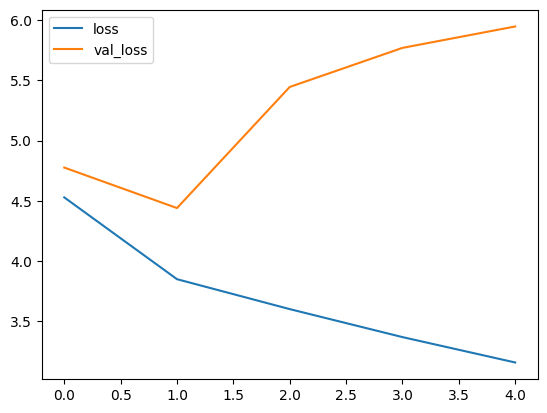

In [20]:
import matplotlib.pyplot as plt
epochs = [i for i in range(EPOCHS)]

plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.show()

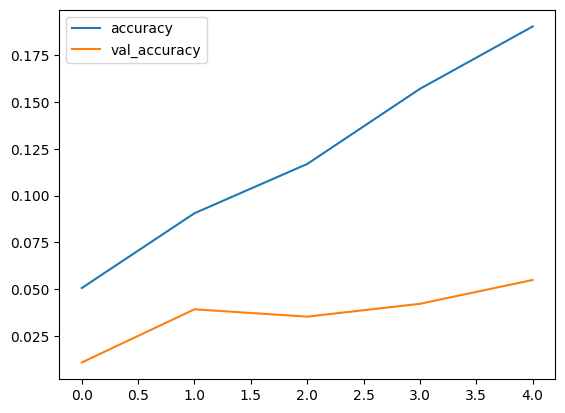

In [21]:
plt.plot(epochs, accuracy, label='accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.legend()
plt.show()

In [22]:
model.summary()

Model: "res_net34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  4160      
                                                                 
 batch_normalization_1 (Batc  multiple                 25

                                                                 
 conv2d_17 (Conv2D)          multiple                  66048     
                                                                 
 batch_normalization_17 (Bat  multiple                 2048      
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  multiple                  0         
                                                                 
 activation_18 (Activation)  multiple                  0         
                                                                 
 conv2d_18 (Conv2D)          multiple                  65664     
                                                                 
 batch_normalization_18 (Bat  multiple                 512       
 chNormalization)                                                
                                                                 
 activatio

                                                                 
 activation_37 (Activation)  multiple                  0         
                                                                 
 conv2d_34 (Conv2D)          multiple                  262400    
                                                                 
 batch_normalization_34 (Bat  multiple                 1024      
 chNormalization)                                                
                                                                 
 activation_38 (Activation)  multiple                  0         
                                                                 
 conv2d_35 (Conv2D)          multiple                  590080    
                                                                 
 batch_normalization_35 (Bat  multiple                 1024      
 chNormalization)                                                
                                                                 
 activatio

                                                                 
 activation_57 (Activation)  multiple                  0         
                                                                 
 conv2d_51 (Conv2D)          multiple                  2359808   
                                                                 
 batch_normalization_51 (Bat  multiple                 2048      
 chNormalization)                                                
                                                                 
 activation_58 (Activation)  multiple                  0         
                                                                 
 conv2d_52 (Conv2D)          multiple                  1050624   
                                                                 
 batch_normalization_52 (Bat  multiple                 8192      
 chNormalization)                                                
                                                                 
 activatio

In [ ]:
model.save('models/ResNet/model')